In [3]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np

In [4]:
class ABENet(nn.Module):
    def __init__(self, N, nkeys=1):
        super(ABENet, self).__init__()
        self.N = N
        
        self.fc    = nn.Linear(in_features=(nkeys+1)*N, out_features=2*N)
        self.conv1 = nn.Conv1d(kernel_size=4, in_channels=1, out_channels=2, stride=1, padding=2)
        self.conv2 = nn.Conv1d(kernel_size=2, in_channels=2, out_channels=4, stride=2)
        self.conv3 = nn.Conv1d(kernel_size=1, in_channels=4, out_channels=4, stride=1)
        self.conv4 = nn.Conv1d(kernel_size=1, in_channels=4, out_channels=1, stride=1)

    def forward(self, x):
        x = torch.sigmoid( self.fc(x) )
        x = x.view(-1, 1, 2*self.N)
        x = torch.sigmoid( self.conv1(x) )
        x = torch.sigmoid( self.conv2(x) )
        x = torch.sigmoid( self.conv3(x) )
        x = torch.tanh(    self.conv4(x) )
        x = x.view(-1, self.N)
        return x

In [5]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=0)

![asymmetric_encryption](img/asymmetric_enc.png)

In [6]:
def reconstruction_error(Out, Original):
    return torch.mean( torch.sum( torch.sign(Original) != torch.sign(Out), dim=1)
                       .to(torch.float), dim=0).item()

In [9]:
N = 16 # [16, 32, 64]
minibatch_size = 4096 # [256..4096]
A = ABENet(N, nkeys=1).to(DEVICE)   # Alice (encrypts with Public key)
B = ABENet(N, nkeys=2).to(DEVICE)   # Bob   (decrypts with Private key)
E = ABENet(N, nkeys=1).to(DEVICE)   # Eve
PG = ABENet(N, nkeys=0).to(DEVICE)   # Public key generator (every party has pub-key)

A_optimizer = optim.Adam(A.parameters(), lr=0.0008)
B_optimizer = optim.Adam(B.parameters(), lr=0.0008)
E_optimizer = optim.Adam(E.parameters(), lr=0.0008)
PG_optimizer = optim.Adam(E.parameters(), lr=0.0008)

l1_norm = nn.L1Loss()
loss_bob, loss_eve = l1_norm, l1_norm
loss_alicebob = lambda P_bob, P_eve, P: loss_bob(P_bob, P) + (((1.0 - loss_eve(P_eve, P))**2))

max_iter = 150000
ABs = []
Es = []
Rec_B = []
Rec_E = []

A.train()
B.train()
E.train()
PG.train()

start_time = time.time()
for ic in range(max_iter):
    for who, num_minibatches in [('AB', 1), ('E', 2)]:
        for _ in range(num_minibatches):
            P = torch.randint(low=0, high=2, size=(minibatch_size,N), dtype=torch.float).to(DEVICE)*2-1
            K = torch.randint(low=0, high=2, size=(minibatch_size,N), dtype=torch.float).to(DEVICE)*2-1
            
            PK    = PG(K)
            C     = A(torch.cat((P, PK), dim=1))
            P_bob = B(torch.cat((C, PK, K), dim=1))
            P_eve = E(torch.cat((C, PK), dim=1))

            if who == 'AB':
                AB_loss = loss_alicebob(P_bob, P_eve, P)
                
                A_optimizer.zero_grad()
                B_optimizer.zero_grad()
                PG_optimizer.zero_grad()
                AB_loss.backward()
                A_optimizer.step()
                B_optimizer.step()
                PG_optimizer.step()
                
            elif who == 'E':
                E_loss  = loss_eve(P_eve, P)

                E_optimizer.zero_grad()
                E_loss.backward()
                E_optimizer.step()

    if ic % 1000 == 999:
        elapsed_time = time.time() - start_time
        print("[{:6d}] AB_loss: {:2.4f} E_loss: {:2.4f} Elapsed Time: {}".format(
            ic+1, AB_loss, E_loss, time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))
    AB_rec = reconstruction_error(P, P_bob)
    E_rec = reconstruction_error(P, P_eve)
    Rec_B.append(AB_rec)
    Rec_E.append(E_rec)
    ABs.append(AB_loss.item())
    Es.append(E_loss.item())
    if AB_loss < 0.005 and E_loss > 0.5: # AB_loss < 0.05 and E_loss > 2
        break


[  1000] AB_loss: 0.9999 E_loss: 1.0001 Elapsed Time: 00:01:23


[  2000] AB_loss: 1.0013 E_loss: 1.0000 Elapsed Time: 00:02:47


[  3000] AB_loss: 0.9966 E_loss: 1.0000 Elapsed Time: 00:04:10


[  4000] AB_loss: 0.9730 E_loss: 0.9940 Elapsed Time: 00:05:34


[  5000] AB_loss: 0.0374 E_loss: 0.8953 Elapsed Time: 00:06:58


[  6000] AB_loss: 0.0543 E_loss: 0.8181 Elapsed Time: 00:08:21


[  7000] AB_loss: 0.3073 E_loss: 0.8048 Elapsed Time: 00:09:45


[  8000] AB_loss: 0.2355 E_loss: 0.7486 Elapsed Time: 00:11:09


[  9000] AB_loss: 0.2387 E_loss: 0.6892 Elapsed Time: 00:12:33


[ 10000] AB_loss: 0.2828 E_loss: 0.6702 Elapsed Time: 00:13:57


[ 11000] AB_loss: 0.3379 E_loss: 0.6501 Elapsed Time: 00:15:20


[ 12000] AB_loss: 0.3008 E_loss: 0.6086 Elapsed Time: 00:16:44


[ 13000] AB_loss: 0.3922 E_loss: 0.5859 Elapsed Time: 00:18:08


[ 14000] AB_loss: 0.3552 E_loss: 0.6118 Elapsed Time: 00:19:32


[ 15000] AB_loss: 0.3886 E_loss: 0.5424 Elapsed Time: 00:20:58


[ 16000] AB_loss: 0.3804 E_loss: 0.5440 Elapsed Time: 00:22:25


[ 17000] AB_loss: 0.4398 E_loss: 0.5158 Elapsed Time: 00:23:53


[ 18000] AB_loss: 0.4119 E_loss: 0.5405 Elapsed Time: 00:25:20


[ 19000] AB_loss: 0.3343 E_loss: 0.5815 Elapsed Time: 00:26:47


[ 20000] AB_loss: 0.3005 E_loss: 0.5883 Elapsed Time: 00:28:11


[ 21000] AB_loss: 0.2846 E_loss: 0.5808 Elapsed Time: 00:29:34


[ 22000] AB_loss: 0.3002 E_loss: 0.5868 Elapsed Time: 00:30:58


[ 23000] AB_loss: 0.3325 E_loss: 0.6190 Elapsed Time: 00:32:22


[ 24000] AB_loss: 0.3206 E_loss: 0.5923 Elapsed Time: 00:33:46


[ 25000] AB_loss: 0.3156 E_loss: 0.5515 Elapsed Time: 00:35:09


[ 26000] AB_loss: 0.3375 E_loss: 0.5397 Elapsed Time: 00:36:33


[ 27000] AB_loss: 0.3327 E_loss: 0.5696 Elapsed Time: 00:37:57


[ 28000] AB_loss: 0.3290 E_loss: 0.5868 Elapsed Time: 00:39:21


[ 29000] AB_loss: 0.3485 E_loss: 0.5762 Elapsed Time: 00:40:44


[ 30000] AB_loss: 0.3613 E_loss: 0.5887 Elapsed Time: 00:42:08


[ 31000] AB_loss: 0.3974 E_loss: 0.5394 Elapsed Time: 00:43:31


[ 32000] AB_loss: 0.3922 E_loss: 0.5477 Elapsed Time: 00:44:55


[ 33000] AB_loss: 0.3955 E_loss: 0.5432 Elapsed Time: 00:46:19


[ 34000] AB_loss: 0.3777 E_loss: 0.5544 Elapsed Time: 00:47:42


[ 35000] AB_loss: 0.3981 E_loss: 0.5691 Elapsed Time: 00:49:07


[ 36000] AB_loss: 0.3856 E_loss: 0.5513 Elapsed Time: 00:50:34


[ 37000] AB_loss: 0.3141 E_loss: 0.6137 Elapsed Time: 00:52:01


[ 38000] AB_loss: 0.3651 E_loss: 0.5538 Elapsed Time: 00:53:29


[ 39000] AB_loss: 0.3588 E_loss: 0.5281 Elapsed Time: 00:54:56


[ 40000] AB_loss: 0.3529 E_loss: 0.5375 Elapsed Time: 00:56:22


[ 41000] AB_loss: 0.3735 E_loss: 0.5228 Elapsed Time: 00:57:46


[ 42000] AB_loss: 0.3724 E_loss: 0.5271 Elapsed Time: 00:59:10


[ 43000] AB_loss: 0.3472 E_loss: 0.5445 Elapsed Time: 01:00:33


[ 44000] AB_loss: 0.3342 E_loss: 0.5328 Elapsed Time: 01:01:57


[ 45000] AB_loss: 0.3148 E_loss: 0.5383 Elapsed Time: 01:03:21


[ 46000] AB_loss: 0.2863 E_loss: 0.5687 Elapsed Time: 01:04:44


[ 47000] AB_loss: 0.2982 E_loss: 0.5394 Elapsed Time: 01:06:08


[ 48000] AB_loss: 0.3205 E_loss: 0.5296 Elapsed Time: 01:07:32


[ 49000] AB_loss: 0.3231 E_loss: 0.5453 Elapsed Time: 01:08:56


[ 50000] AB_loss: 0.3061 E_loss: 0.5499 Elapsed Time: 01:10:19


[ 51000] AB_loss: 0.2891 E_loss: 0.5664 Elapsed Time: 01:11:43


[ 52000] AB_loss: 0.2741 E_loss: 0.5869 Elapsed Time: 01:13:07


[ 53000] AB_loss: 0.2557 E_loss: 0.5926 Elapsed Time: 01:14:31


[ 54000] AB_loss: 0.2582 E_loss: 0.5932 Elapsed Time: 01:15:55


[ 55000] AB_loss: 0.2488 E_loss: 0.6104 Elapsed Time: 01:17:18


[ 56000] AB_loss: 0.2746 E_loss: 0.5914 Elapsed Time: 01:18:44


[ 57000] AB_loss: 0.3025 E_loss: 0.5676 Elapsed Time: 01:20:11


[ 58000] AB_loss: 0.2711 E_loss: 0.5852 Elapsed Time: 01:21:38


[ 59000] AB_loss: 0.2903 E_loss: 0.5725 Elapsed Time: 01:23:06


[ 60000] AB_loss: 0.2952 E_loss: 0.5638 Elapsed Time: 01:24:33


[ 61000] AB_loss: 0.2996 E_loss: 0.5615 Elapsed Time: 01:26:01


[ 62000] AB_loss: 0.3183 E_loss: 0.5360 Elapsed Time: 01:27:28


[ 63000] AB_loss: 0.3194 E_loss: 0.5302 Elapsed Time: 01:28:55


[ 64000] AB_loss: 0.3029 E_loss: 0.5641 Elapsed Time: 01:30:23


[ 65000] AB_loss: 0.2988 E_loss: 0.5716 Elapsed Time: 01:31:48


[ 66000] AB_loss: 0.3081 E_loss: 0.5621 Elapsed Time: 01:33:12


[ 67000] AB_loss: 0.3010 E_loss: 0.5668 Elapsed Time: 01:34:35


[ 68000] AB_loss: 0.3075 E_loss: 0.5693 Elapsed Time: 01:35:59


[ 69000] AB_loss: 0.2750 E_loss: 0.5801 Elapsed Time: 01:37:23


[ 70000] AB_loss: 0.2989 E_loss: 0.5567 Elapsed Time: 01:38:47


[ 71000] AB_loss: 0.2872 E_loss: 0.5799 Elapsed Time: 01:40:10


[ 72000] AB_loss: 0.2821 E_loss: 0.5848 Elapsed Time: 01:41:34


[ 73000] AB_loss: 0.2645 E_loss: 0.6438 Elapsed Time: 01:42:58


[ 74000] AB_loss: 0.2764 E_loss: 0.6206 Elapsed Time: 01:44:22


[ 75000] AB_loss: 0.3018 E_loss: 0.5862 Elapsed Time: 01:45:46


[ 76000] AB_loss: 0.3103 E_loss: 0.5882 Elapsed Time: 01:47:09


[ 77000] AB_loss: 0.2502 E_loss: 0.5969 Elapsed Time: 01:48:33


[ 78000] AB_loss: 0.2702 E_loss: 0.5757 Elapsed Time: 01:49:57


[ 79000] AB_loss: 0.2919 E_loss: 0.5616 Elapsed Time: 01:51:21


[ 80000] AB_loss: 0.2882 E_loss: 0.5734 Elapsed Time: 01:52:44


[ 81000] AB_loss: 0.2951 E_loss: 0.5879 Elapsed Time: 01:54:10


[ 82000] AB_loss: 0.2969 E_loss: 0.5618 Elapsed Time: 01:55:38


[ 83000] AB_loss: 0.3238 E_loss: 0.5472 Elapsed Time: 01:57:05


[ 84000] AB_loss: 0.3449 E_loss: 0.5696 Elapsed Time: 01:58:32


[ 85000] AB_loss: 0.3458 E_loss: 0.5496 Elapsed Time: 01:59:56


[ 86000] AB_loss: 0.3149 E_loss: 0.6189 Elapsed Time: 02:01:20


[ 87000] AB_loss: 0.3387 E_loss: 0.6071 Elapsed Time: 02:02:44


[ 88000] AB_loss: 0.3496 E_loss: 0.5734 Elapsed Time: 02:04:07


[ 89000] AB_loss: 0.3209 E_loss: 0.5814 Elapsed Time: 02:05:31


[ 90000] AB_loss: 0.2999 E_loss: 0.6015 Elapsed Time: 02:06:55


[ 91000] AB_loss: 0.2829 E_loss: 0.5975 Elapsed Time: 02:08:19


[ 92000] AB_loss: 0.3052 E_loss: 0.5624 Elapsed Time: 02:09:42


[ 93000] AB_loss: 0.3052 E_loss: 0.5963 Elapsed Time: 02:11:06


[ 94000] AB_loss: 0.2917 E_loss: 0.5921 Elapsed Time: 02:12:30


[ 95000] AB_loss: 0.2827 E_loss: 0.6133 Elapsed Time: 02:13:54


[ 96000] AB_loss: 0.3033 E_loss: 0.5916 Elapsed Time: 02:15:17


[ 97000] AB_loss: 0.3249 E_loss: 0.5568 Elapsed Time: 02:16:41


[ 98000] AB_loss: 0.3335 E_loss: 0.5605 Elapsed Time: 02:18:05


[ 99000] AB_loss: 0.3522 E_loss: 0.5453 Elapsed Time: 02:19:28


[100000] AB_loss: 0.3919 E_loss: 0.5253 Elapsed Time: 02:20:52


[101000] AB_loss: 0.2984 E_loss: 0.5980 Elapsed Time: 02:22:19


[102000] AB_loss: 0.2945 E_loss: 0.6142 Elapsed Time: 02:23:46


[103000] AB_loss: 0.2395 E_loss: 0.6410 Elapsed Time: 02:25:14


[104000] AB_loss: 0.2756 E_loss: 0.6044 Elapsed Time: 02:26:41


[105000] AB_loss: 0.2908 E_loss: 0.5971 Elapsed Time: 02:28:08


[106000] AB_loss: 0.2835 E_loss: 0.6052 Elapsed Time: 02:29:35


[107000] AB_loss: 0.2784 E_loss: 0.6220 Elapsed Time: 02:30:59


[108000] AB_loss: 0.2686 E_loss: 0.6004 Elapsed Time: 02:32:23


[109000] AB_loss: 0.3034 E_loss: 0.5549 Elapsed Time: 02:33:46


[110000] AB_loss: 0.3082 E_loss: 0.5717 Elapsed Time: 02:35:10


[111000] AB_loss: 0.3071 E_loss: 0.6067 Elapsed Time: 02:36:34


[112000] AB_loss: 0.2929 E_loss: 0.6154 Elapsed Time: 02:37:58


[113000] AB_loss: 0.3085 E_loss: 0.5983 Elapsed Time: 02:39:21


[114000] AB_loss: 0.3106 E_loss: 0.6293 Elapsed Time: 02:40:45


[115000] AB_loss: 0.3074 E_loss: 0.5779 Elapsed Time: 02:42:08


[116000] AB_loss: 0.2786 E_loss: 0.5900 Elapsed Time: 02:43:32


[117000] AB_loss: 0.2795 E_loss: 0.6259 Elapsed Time: 02:44:56


[118000] AB_loss: 0.2599 E_loss: 0.6233 Elapsed Time: 02:46:20


[119000] AB_loss: 0.2147 E_loss: 0.6587 Elapsed Time: 02:47:43


[120000] AB_loss: 0.2154 E_loss: 0.6712 Elapsed Time: 02:49:07


[121000] AB_loss: 0.2202 E_loss: 0.6613 Elapsed Time: 02:50:31


[122000] AB_loss: 0.2213 E_loss: 0.6349 Elapsed Time: 02:51:55


[123000] AB_loss: 0.2238 E_loss: 0.6306 Elapsed Time: 02:53:22


[124000] AB_loss: 0.2197 E_loss: 0.6537 Elapsed Time: 02:54:49


[125000] AB_loss: 0.2140 E_loss: 0.6345 Elapsed Time: 02:56:17


[126000] AB_loss: 0.1337 E_loss: 0.6908 Elapsed Time: 02:57:44


[127000] AB_loss: 0.1883 E_loss: 0.6698 Elapsed Time: 02:59:12


[128000] AB_loss: 0.1965 E_loss: 0.6404 Elapsed Time: 03:00:39


[129000] AB_loss: 0.1970 E_loss: 0.6513 Elapsed Time: 03:02:02


[130000] AB_loss: 0.1949 E_loss: 0.6492 Elapsed Time: 03:03:26


[131000] AB_loss: 0.1596 E_loss: 0.6612 Elapsed Time: 03:04:50


[132000] AB_loss: 0.1697 E_loss: 0.6652 Elapsed Time: 03:06:13


[133000] AB_loss: 0.1755 E_loss: 0.6566 Elapsed Time: 03:07:37


[134000] AB_loss: 0.2122 E_loss: 0.6383 Elapsed Time: 03:09:01


[135000] AB_loss: 0.2173 E_loss: 0.6300 Elapsed Time: 03:10:25


[136000] AB_loss: 0.2315 E_loss: 0.6166 Elapsed Time: 03:11:49


[137000] AB_loss: 0.1769 E_loss: 0.6808 Elapsed Time: 03:13:13


[138000] AB_loss: 0.1898 E_loss: 0.6615 Elapsed Time: 03:14:37


[139000] AB_loss: 0.1815 E_loss: 0.6628 Elapsed Time: 03:16:01


[140000] AB_loss: 0.2102 E_loss: 0.6566 Elapsed Time: 03:17:25


[141000] AB_loss: 0.2086 E_loss: 0.6931 Elapsed Time: 03:18:48


[142000] AB_loss: 0.1711 E_loss: 0.6677 Elapsed Time: 03:20:12


[143000] AB_loss: 0.1606 E_loss: 0.6901 Elapsed Time: 03:21:36


[144000] AB_loss: 0.1651 E_loss: 0.6909 Elapsed Time: 03:22:59


[145000] AB_loss: 0.1670 E_loss: 0.6919 Elapsed Time: 03:24:27


[146000] AB_loss: 0.1474 E_loss: 0.6906 Elapsed Time: 03:25:54


[147000] AB_loss: 0.1531 E_loss: 0.6939 Elapsed Time: 03:27:22


[148000] AB_loss: 0.1423 E_loss: 0.6931 Elapsed Time: 03:28:49


[149000] AB_loss: 0.1453 E_loss: 0.6801 Elapsed Time: 03:30:17


[150000] AB_loss: 0.1300 E_loss: 0.7084 Elapsed Time: 03:31:44


/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


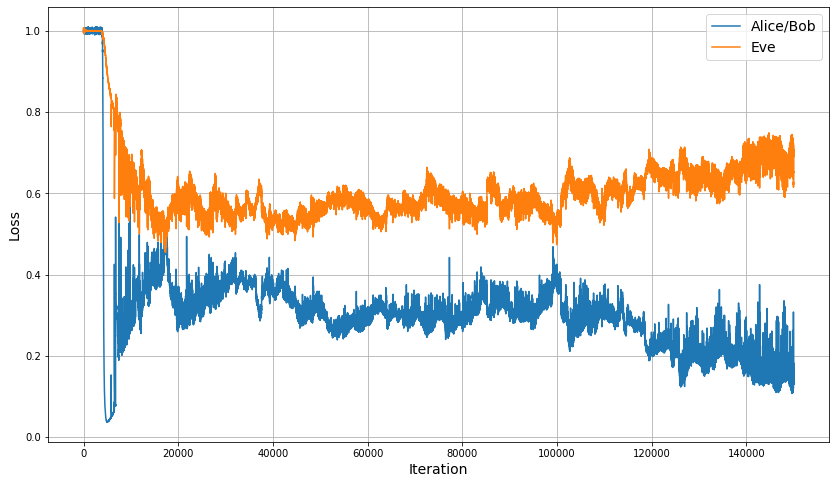

In [11]:
plt.figure(figsize=(14,8))
plt.plot(range(1, len(ABs)+1), ABs, label='Alice/Bob')
plt.plot(range(1, len(Es)+1), Es, label='Eve')
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=14)
plt.grid(True, which='both')
plt.show()

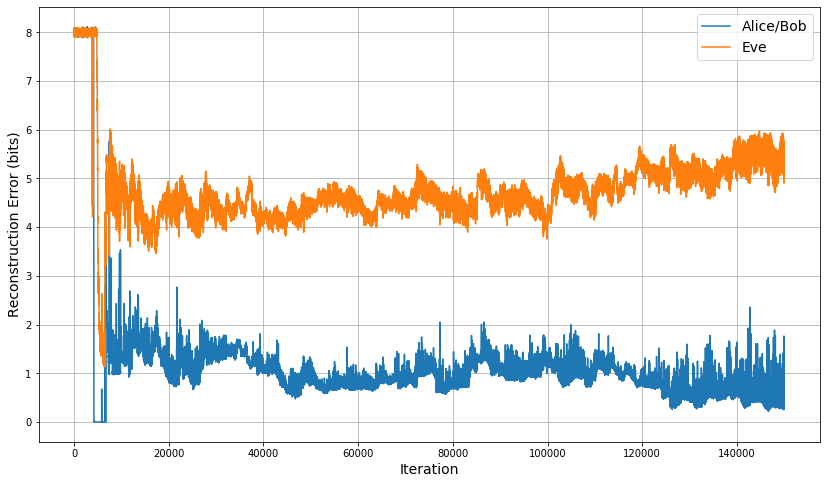

In [12]:
plt.figure(figsize=(14,8))
plt.plot(range(1, len(Rec_B)+1), Rec_B, label='Alice/Bob')
plt.plot(range(1, len(Rec_E)+1), Rec_E, label='Eve')
plt.xlabel("Iteration", fontsize=14)
plt.ylabel("Reconstruction Error (bits)", fontsize=14)
plt.legend(fontsize=14)
plt.grid(True, which='both')
plt.show()

In [17]:
def train_best_eve(PG, A,
                   max_iter=250000,
                   retries=5,
                   debug_print=10000):

    Best_E_Rec = float("Inf")
    Best_E_loss = float("Inf")
    Best_E = None

    for es in range(retries):
        CE = ABENet(N, nkeys=1).to(DEVICE)
        CE_optimizer = optim.Adam(CE.parameters(), lr=0.0008)
        CE.train()
        start_time = time.time()
        for ic in range(max_iter):
            P = torch.randint(low=0, high=2, size=(minibatch_size,N), dtype=torch.float).to(DEVICE)*2-1
            K = torch.randint(low=0, high=2, size=(minibatch_size,N), dtype=torch.float).to(DEVICE)*2-1
            
            PK    = PG(K)
            C     = A(torch.cat((P, PK), dim=1))
            P_eve = CE(torch.cat((C, PK), dim=1))
            CE_loss = loss_eve(P_eve, P)
            
            CE_optimizer.zero_grad()
            CE_loss.backward()
            CE_optimizer.step()

            if debug_print > 0 and ic % debug_print == (debug_print-1):
                elapsed_time = time.time() - start_time
                print("[{:d} - {:6d}] CE_loss: {:2.4f} Elapsed Time: {}".format(
                    es+1, ic+1, CE_loss, time.strftime("%H:%M:%S", time.gmtime(elapsed_time))))

            if CE_loss <= 0.05:
                raise RuntimeError("Optimal E found!")
                break
            
        if CE_loss.item() < Best_E_loss:
            Best_E_loss = CE_loss.item()
            Best_E = CE
            Best_E_Rec = reconstruction_error(P, P_eve)

    return Best_E, Best_E_loss, Best_E_Rec

In [18]:
Best_E, Best_E_loss, Best_E_Rec = train_best_eve(PG, A, retries=1, max_iter=40000)
Best_E_loss

[1 -  10000] CE_loss: 0.2001 Elapsed Time: 00:04:00


[1 -  20000] CE_loss: 0.1211 Elapsed Time: 00:08:01


[1 -  30000] CE_loss: 0.0900 Elapsed Time: 00:12:01


[1 -  40000] CE_loss: 0.0809 Elapsed Time: 00:16:05


0.08091798424720764